# Temperature on Electricity Demand (New England)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
#import warnings 
%pip install xlrd==2.0.1

%matplotlib inline



Note: you may need to restart the kernel to use updated packages.


## Context 
Electricty markets are highly correlated to temperature fluctuations and weather patterns. Given a particular generation mix, pool prices per KwH can fluctuate wildly if the sun is shining brightly, or evening temperatures are colder than usual.[cite research probably?] 

## Data Cleaning

### Electricity Demand + Price + Temperature (Hourly)

https://www.iso-ne.com/isoexpress/

In [2]:
states = ['ISONE CA', 'ME', 'NH', 'VT', 'CT', 'RI', 'SEMASS' ,'WCMASS', 'NEMASSBOST']

state_dfs = [pd.DataFrame(columns=['Date', 'Hour', 'DA Demand', 'RT Demand',
                                   'DA Price', 'RT Price', 'Temperature', 'Region']) for _ in states]

state_names = ['isone_ca', 'me', 'nh', 'vt', 'ct', 'ri', 'sema', 'wcma', 'nema']

state_names_full = ['ISO-NE Control Area', 'Maine', 'New Hampshire', 'Vermont',
                    'Connecticut', 'Rhode Island', 'SouthEastern Massachusetts',
                    'Western & Central Massachusetts', 'NorthEastern Massachusetts & Boston']

#### DO NOT TOUCH (Cleaning for final project)

In [3]:
"""
THIS IS THE CLEANING CODE FOR THE RAW DATA, DO NOT TOUCH IT
"""

# for year in range(2011, 2018):
#     path = f"data/demand/{year}_smd_hourly.xls"
#     if year >= 2016:
#         for i, state in enumerate(states):
#             state_df = pd.read_excel(path, sheet_name = state)
#             state_df = state_df[['Date', 'Hr_End', 'DA_Demand', 'RT_Demand', 'DA_LMP', 'RT_LMP', 'Dry_Bulb']]
#             state_df = state_df.rename(columns = {'RT_Demand' : 'RT Demand', 'Dry_Bulb' : 'Temperature',
#                                                     'DA_Demand' : 'DA Demand', 'DA_LMP' : 'DA Price',
#                                                     'RT_LMP' : 'RT Price', 'Hr_End' : 'Hour'})
#             state_df['Date'] = pd.to_datetime(state_df['Date'], format = 'dd/mm/yy')
#             state_df['Region'] = state_names_full[i]
            
#             state_dfs[i] = pd.concat([state_dfs[i], state_df], ignore_index = True)
#     else:
#         for i, state in enumerate(states):
#             state_df = pd.read_excel(path, sheet_name = state)
#             state_df = state_df[['Date', 'Hour', 'DA_DEMD', 'DEMAND', 'DA_LMP', 'RT_LMP', 'DryBulb']]
#             state_df = state_df.rename(columns = {'DEMAND' : 'RT Demand', 'DryBulb' : 'Temperature',
#                                                     'DA_DEMD' : 'DA Demand', 'DA_LMP' : 'DA Price',
#                                                     'RT_LMP' : 'RT Price'})
#             state_df['Date'] = pd.to_datetime(state_df['Date'], format = 'dd/mm/yy')
#             state_df['Region'] = state_names_full[i]
            
#             state_dfs[i] = pd.concat([state_dfs[i], state_df], ignore_index = True)
            
# for i in range(len(state_dfs)):
#     #Set index as datetime
#     state_dfs[i]['Datetime'] = pd.to_datetime(state_dfs[i]['Date']) + pd.to_timedelta(state_dfs[i]['Hour'], unit='h')
#     state_dfs[i] = state_dfs[i].set_index('Datetime')
    
#     #Add Year column
#     state_dfs[i]['Year'] = pd.to_datetime(state_dfs[i]['Date']).dt.year
#     columns = ['Year', 'Region'] + [col for col in state_dfs[i].columns if col not in ['Year', 'Region']]
#     state_dfs[i] = state_dfs[i][columns]
    
#     #Remove all rows with 0 demand
#     state_dfs[i] = state_dfs[i][state_dfs[i]['RT Demand'] != 0]

'\nTHIS IS THE CLEANING CODE FOR THE RAW DATA, DO NOT TOUCH IT\n'

In [4]:
for i in range(len(state_names)):
    path = f"data/Others/demand/{state_names[i]}.csv"
    state_dfs[i] = pd.read_csv(path)
    state_dfs[i]["Date"] = pd.to_datetime(state_dfs[i]["Date"])

In [5]:
state_dfs[1].head()

,Year,Region,Date,Hour,DA Demand,RT Demand,DA Price,RT Price,Temperature
0,2011,Maine,2011-01-01,1,952.2,1048.0,37.80,40.68,31
1,2011,Maine,2011-01-01,2,905.2,1000.0,36.27,33.92,31
2,2011,Maine,2011-01-01,3,860.6,964.0,35.41,34.27,32
3,2011,Maine,2011-01-01,4,843.9,954.0,35.40,32.96,35
4,2011,Maine,2011-01-01,5,863.9,960.0,35.59,32.51,34


### Natural Gas Prices (Daily)

https://www.eia.gov/dnav/ng/ng_pri_sum_a_EPG0_PG1_DMcf_m.htm

We control for natural gas prices because 

In [6]:
ng = pd.read_excel('data/NG_PRI_SUM_A_EPG0_PG1_DMCF_M.xls', sheet_name = 'Data 1',
                   skiprows = 2)

ng = ng[['Date', 'Natural Gas Citygate Price in Connecticut (Dollars per Thousand Cubic Feet)', 
         'Natural Gas Citygate Price in Maine (Dollars per Thousand Cubic Feet)', 
         'Natural Gas Citygate Price in Massachusetts (Dollars per Thousand Cubic Feet)', 
         'Natural Gas Citygate Price in New Hampshire (Dollars per Thousand Cubic Feet)',
         'Natural Gas Citygate Price in Rhode Island (Dollars per Thousand Cubic Feet)',
         'Natural Gas Citygate Price in Vermont (Dollars per Thousand Cubic Feet)']]

ng.columns = ['Date', 'Connecticut', 'Maine', 'Massachusetts', 'New Hampshire', 'Rhode Island', 'Vermont']

ng = ng[(ng['Date'] >= '2011-01-01') & (ng['Date'] <= '2017-12-31')]

ng['year_month'] = ng['Date'].dt.to_period('M')

ng.head()

,Date,Connecticut,Maine,Massachusetts,New Hampshire,Rhode Island,Vermont,year_month
456,2011-01-15,5.74,7.59,6.70,8.06,7.82,7.60,2011-01
457,2011-02-15,5.93,7.24,6.90,7.22,7.62,7.72,2011-02
458,2011-03-15,5.66,8.65,6.57,8.30,7.03,8.04,2011-03
459,2011-04-15,5.87,7.53,7.25,7.72,7.09,8.69,2011-04
460,2011-05-15,6.67,9.97,7.84,7.95,9.80,8.87,2011-05


In [7]:
for i in range(len(state_dfs)):
    state_dfs[i]['year_month'] = state_dfs[i]['Date'].dt.to_period('M')
    #All New England - no NG price data
    if i == 0:
        state_dfs[i].drop(columns = ['year_month'], inplace = True)
        continue
    #Maine
    elif i == 1:
        state_dfs[i] = pd.merge(state_dfs[i], ng[['year_month', 'Maine']], on = 'year_month', how = 'left')
        state_dfs[i] = state_dfs[i].rename(columns={'Maine': 'Natural Gas Price'})
    #New Hampsphire
    elif i == 2:
        state_dfs[i] = pd.merge(state_dfs[i], ng[['year_month', 'New Hampshire']], on = 'year_month', how = 'left')
        state_dfs[i] = state_dfs[i].rename(columns={'New Hampshire': 'Natural Gas Price'})
    #Vermont
    elif i == 3:
        state_dfs[i] = pd.merge(state_dfs[i], ng[['year_month', 'Vermont']], on = 'year_month', how = 'left')
        state_dfs[i] = state_dfs[i].rename(columns={'Vermont': 'Natural Gas Price'})
    #Connecticut
    elif i == 4:
        state_dfs[i] = pd.merge(state_dfs[i], ng[['year_month', 'Connecticut']], on = 'year_month', how = 'left')
        state_dfs[i] = state_dfs[i].rename(columns={'Connecticut': 'Natural Gas Price'})
    #Rhode Island
    elif i == 5:
        state_dfs[i] = pd.merge(state_dfs[i], ng[['year_month', 'Rhode Island']], on = 'year_month', how = 'left')
        state_dfs[i] = state_dfs[i].rename(columns={'Rhode Island': 'Natural Gas Price'})
    #Massachusetts
    else:
        state_dfs[i] = pd.merge(state_dfs[i], ng[['year_month', 'Massachusetts']], on = 'year_month', how = 'left')
        state_dfs[i] = state_dfs[i].rename(columns={'Massachusetts': 'Natural Gas Price'})
    state_dfs[i].drop(columns = ['year_month'], inplace = True)

In [30]:
state_dfs[1].head()

,Year,Region,Date,Hour,DA Demand,RT Demand,DA Price,RT Price,Temperature,Natural Gas Price,...,Nuclear Pct,Oil Pct,Landfill Gas Pct,Methane Pct,Refuse Pct,Solar Pct,Wind Pct,Wood Pct,Demand Diff,Price Diff
Datetime,,,,,,,,,,,,,,,,,,,,,
2011-01-01 01:00:00,2011,Maine,2011-01-01,1,952.2,1048.0,37.80,40.68,31,7.59,...,39.675959,-0.010543,0.467302,0.048537,3.356947,0.003067,0.396945,2.747382,95.8,2.88
2011-01-01 02:00:00,2011,Maine,2011-01-01,2,905.2,1000.0,36.27,33.92,31,7.59,...,39.675959,-0.010543,0.467302,0.048537,3.356947,0.003067,0.396945,2.747382,94.8,-2.35
2011-01-01 03:00:00,2011,Maine,2011-01-01,3,860.6,964.0,35.41,34.27,32,7.59,...,39.675959,-0.010543,0.467302,0.048537,3.356947,0.003067,0.396945,2.747382,103.4,-1.14
2011-01-01 04:00:00,2011,Maine,2011-01-01,4,843.9,954.0,35.40,32.96,35,7.59,...,39.675959,-0.010543,0.467302,0.048537,3.356947,0.003067,0.396945,2.747382,110.1,-2.44
2011-01-01 05:00:00,2011,Maine,2011-01-01,5,863.9,960.0,35.59,32.51,34,7.59,...,39.675959,-0.010543,0.467302,0.048537,3.356947,0.003067,0.396945,2.747382,96.1,-3.08


### Generation Mix (Daily)

https://www.iso-ne.com/isoexpress/web/reports/operations/-/tree/daily-gen-fuel-type

In [9]:
dataframes_genmix = []
pct_data = []

for year_genmix in range(2011, 2018):
    # Define the path to your file for the current year
    data_path_genmix = f"data/gen_mix/{year_genmix}_daygenbyfuel.xlsx"
    sheet = "POST-EMOF Fuel Types" if year_genmix <= 2013 else "POST-EMOF Gen_w_Blending"

    # Read the data from the specific sheet for each year
    genmix_df = pd.read_excel(data_path_genmix, sheet_name=sheet)
    
    genmix_df = genmix_df.dropna(subset=['DATE'])
    genmix_df['DATE'] = pd.to_datetime(genmix_df['DATE'], format='%m/%d/%Y', errors='coerce')

    dataframes_genmix.append(genmix_df)
    
    #Percentage Dataframe
    genmix_pct = genmix_df.copy()
    
    for col in genmix_pct.columns:
        if col != 'DATE':
            genmix_pct[col] = genmix_pct[col] / genmix_pct['TOTAL'] * 100
    
    pct_data.append(genmix_pct)
    

#Fuel Data
final_genmix_df = pd.concat(dataframes_genmix, ignore_index=True)
final_genmix_df.columns = [col.title() for col in final_genmix_df.columns]
final_genmix_df = final_genmix_df.drop(columns = ['Total'])

#Percentage Data
genmix_pct = pd.concat(pct_data, ignore_index=True)
genmix_pct = genmix_pct.drop(columns = ['TOTAL', 'OTHER', 'STEAM'])
genmix_pct.columns = [col.title() for col in genmix_pct.columns]
genmix_pct.columns = [col + " Pct" if col != 'Date' else col for col in genmix_pct.columns]

#### DataFrame for all Fuel Types (for Visualizations)

In [10]:
final_genmix_df.head()

,Date,Coal,Gas,Hydro,Nuclear,Oil,Landfill Gas,Methane,Refuse,Solar,Steam,Wind,Wood,Other
0,2011-01-01,20552.396,108641.394,20919.195,112147.889,-29.800,1320.874,137.195,9488.731,8.670,555.0,1122.004,7765.738,NaN
1,2011-01-02,20163.527,117377.411,25181.303,112143.165,865.881,1361.649,136.302,9711.649,6.816,554.0,1433.706,7768.051,NaN
2,2011-01-03,27166.663,160266.142,29681.796,112054.041,-55.636,1305.818,141.241,9641.529,15.152,535.0,4644.886,8129.366,NaN
3,2011-01-04,38256.357,154016.112,27829.059,112125.295,-56.624,1281.397,133.375,8517.200,7.716,589.0,3340.066,8404.685,NaN
4,2011-01-05,39574.746,155309.212,29021.944,112105.759,978.276,1230.426,136.396,8044.773,11.592,589.0,4021.743,8509.108,NaN


#### Adding Fuel Type Percentages to state_dfs

In [11]:
genmix_pct.head()

,Date,Coal Pct,Gas Pct,Hydro Pct,Nuclear Pct,Oil Pct,Landfill Gas Pct,Methane Pct,Refuse Pct,Solar Pct,Wind Pct,Wood Pct
0,2011-01-01,7.271078,38.435423,7.400845,39.675959,-0.010543,0.467302,0.048537,3.356947,0.003067,0.396945,2.747382
1,2011-01-02,6.795176,39.556577,8.486183,37.792619,0.291805,0.458880,0.045934,3.272858,0.002297,0.483164,2.617859
2,2011-01-03,7.682999,45.324840,8.394304,31.689984,-0.015734,0.369298,0.039944,2.726719,0.004285,1.313619,2.299065
3,2011-01-04,10.791102,43.443852,7.849838,31.627566,-0.015972,0.361448,0.037622,2.402476,0.002176,0.942144,2.370738
4,2011-01-05,11.005052,43.188803,8.070500,31.174671,0.272042,0.342160,0.037929,2.237112,0.003224,1.118377,2.366236


In [12]:
for i in range(len(state_dfs)):
    state_dfs[i] = pd.merge(state_dfs[i], genmix_pct, how = 'left', on = 'Date')
    state_dfs[i]['Datetime'] = pd.to_datetime(state_dfs[i]['Date']) + pd.to_timedelta(state_dfs[i]['Hour'], unit='h')
    state_dfs[i] = state_dfs[i].set_index('Datetime')

In [31]:
#Final Data
state_dfs[1]

,Year,Region,Date,Hour,DA Demand,RT Demand,DA Price,RT Price,Temperature,Natural Gas Price,...,Nuclear Pct,Oil Pct,Landfill Gas Pct,Methane Pct,Refuse Pct,Solar Pct,Wind Pct,Wood Pct,Demand Diff,Price Diff
Datetime,,,,,,,,,,,,,,,,,,,,,
2011-01-01 01:00:00,2011,Maine,2011-01-01,1,952.2,1048.000,37.80,40.68,31,7.59,...,39.675959,-0.010543,0.467302,0.048537,3.356947,0.003067,0.396945,2.747382,95.800,2.88
2011-01-01 02:00:00,2011,Maine,2011-01-01,2,905.2,1000.000,36.27,33.92,31,7.59,...,39.675959,-0.010543,0.467302,0.048537,3.356947,0.003067,0.396945,2.747382,94.800,-2.35
2011-01-01 03:00:00,2011,Maine,2011-01-01,3,860.6,964.000,35.41,34.27,32,7.59,...,39.675959,-0.010543,0.467302,0.048537,3.356947,0.003067,0.396945,2.747382,103.400,-1.14
2011-01-01 04:00:00,2011,Maine,2011-01-01,4,843.9,954.000,35.40,32.96,35,7.59,...,39.675959,-0.010543,0.467302,0.048537,3.356947,0.003067,0.396945,2.747382,110.100,-2.44
2011-01-01 05:00:00,2011,Maine,2011-01-01,5,863.9,960.000,35.59,32.51,34,7.59,...,39.675959,-0.010543,0.467302,0.048537,3.356947,0.003067,0.396945,2.747382,96.100,-3.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-31 20:00:00,2017,Maine,2017-12-31,20,1531.1,1696.392,212.49,179.49,2,7.90,...,28.220029,26.210968,0.352507,0.036100,2.889132,0.099822,5.310015,3.166308,165.292,-33.00
2017-12-31 21:00:00,2017,Maine,2017-12-31,21,1459.3,1652.438,209.58,164.02,1,7.90,...,28.220029,26.210968,0.352507,0.036100,2.889132,0.099822,5.310015,3.166308,193.138,-45.56
2017-12-31 22:00:00,2017,Maine,2017-12-31,22,1352.6,1577.769,176.66,132.54,0,7.90,...,28.220029,26.210968,0.352507,0.036100,2.889132,0.099822,5.310015,3.166308,225.169,-44.12


## Data Analysis

**state_dfs** is a list containing 9 dataframes, index the list to access each region

This is the order of the regions: state_names = ['isone_ca', 'me', 'nh', 'vt', 'ct', 'ri', 'sema', 'wcma', 'nema']

**ng** is a dataframe containing natural gas prices (columns: regions, rows: date)

**final_genmix_df** is a dataframe containing fuel type distribution in generation mix (columns: fuel type, rows: date)

### Electricity Demand, Price and Temperature

Text(0.5, 1.0, 'Electricity Demand on Temperature (Entire ISO-NE)')

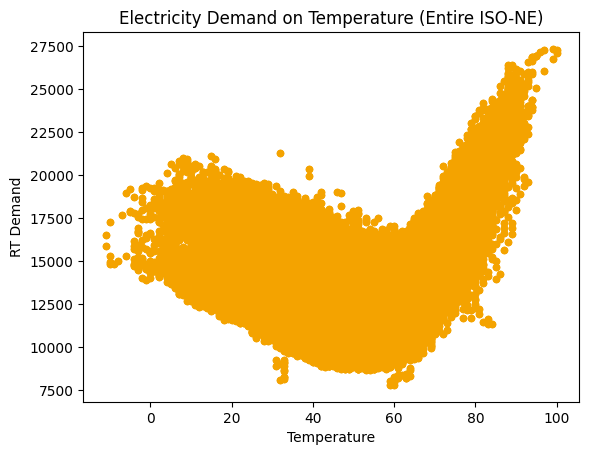

In [14]:
state_dfs[0].plot.scatter('Temperature', 'RT Demand', color = '#F4A300')
plt.title('Electricity Demand on Temperature (Entire ISO-NE)')

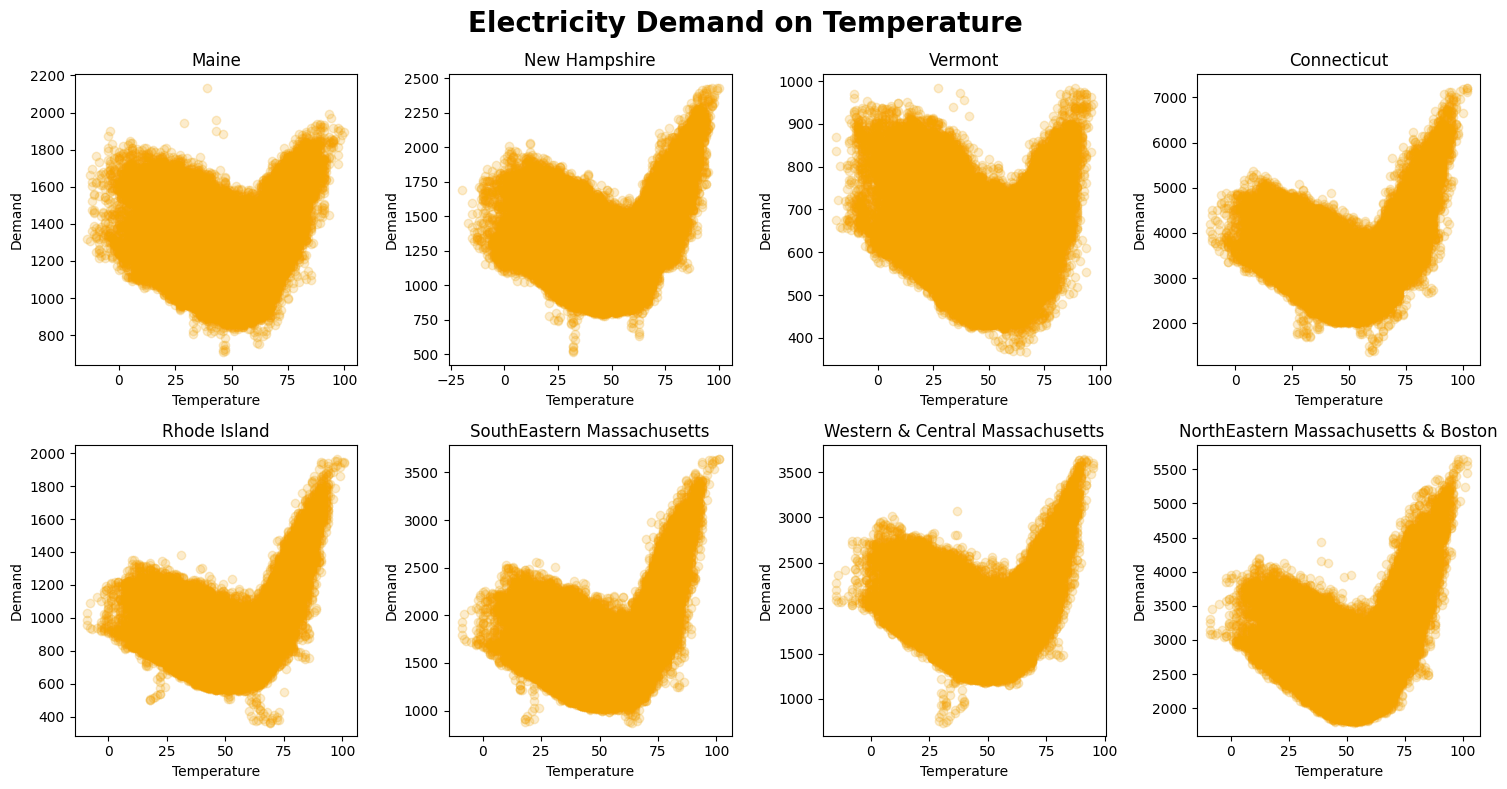

In [35]:
# Assuming `state_dfs` is a list of 8 DataFrames and `state_names` is a list of 8 titles
fig, axes = plt.subplots(2, 4, figsize=(15, 8))  # Creates a 2x4 grid of subplots

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through each DataFrame and corresponding title
for i, (df, name) in enumerate(zip(state_dfs[1:], state_names_full[1:])):
    axes[i].scatter(df['Temperature'], df['RT Demand'], alpha = 0.1, color = '#F4A300')
    axes[i].set_title(name)
    axes[i].set_ylabel('Demand')
    axes[i].set_xlabel('Temperature')

fig.suptitle('Electricity Demand on Temperature', fontsize=20, fontweight='bold')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [16]:
for i in range(len(state_dfs)):
    state_dfs[i]['Demand Diff'] = state_dfs[i]['RT Demand'] - state_dfs[i]['DA Demand']
    state_dfs[i]['Price Diff'] = state_dfs[i]['RT Price'] - state_dfs[i]['DA Price']

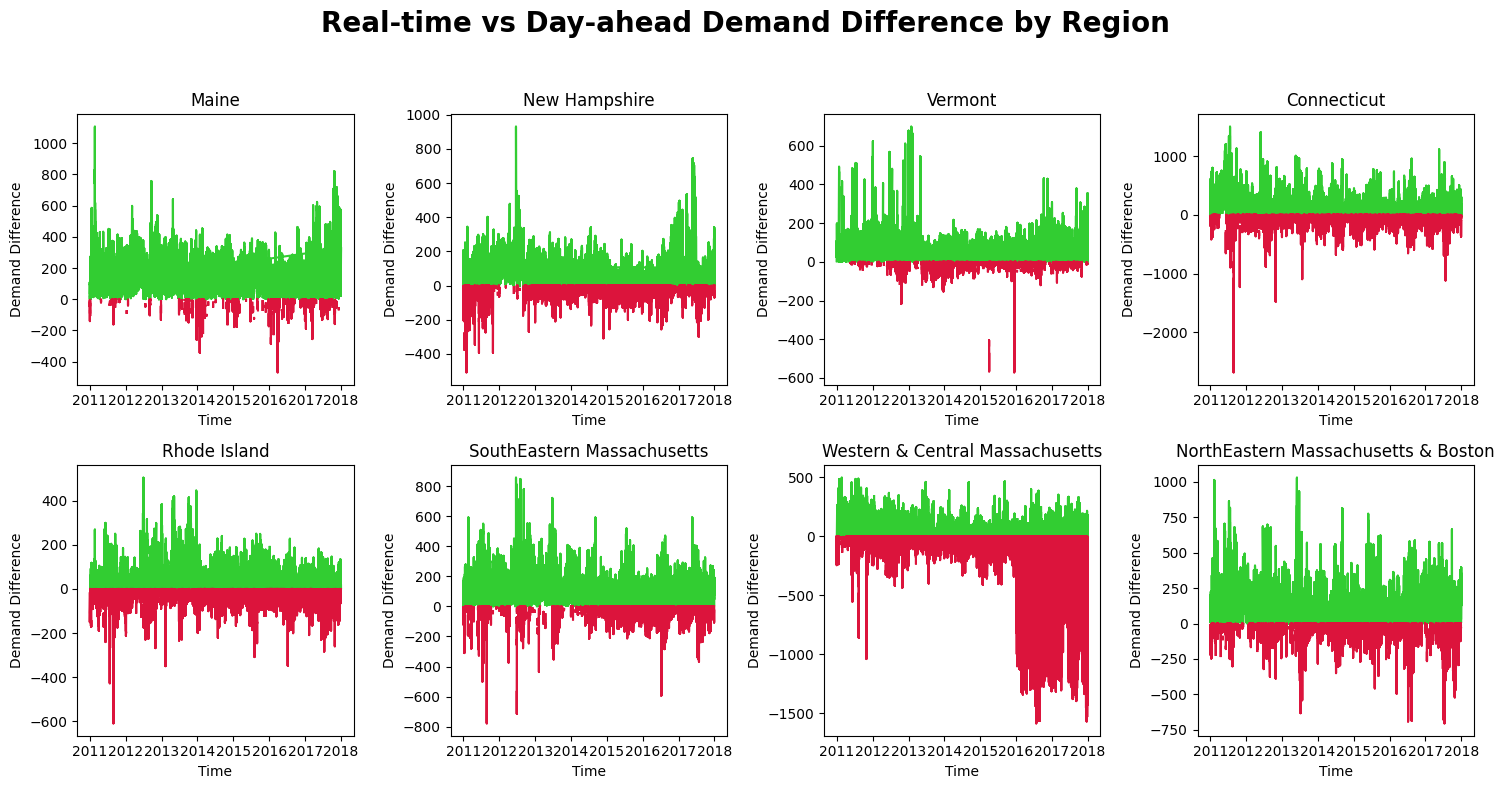

In [17]:
fig, axes = plt.subplots(2, 4, figsize=(15, 8))  # Creates a 2x4 grid of subplots

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through each DataFrame and corresponding title
for i, (df, name) in enumerate(zip(state_dfs[1:], state_names_full[1:])):  # Assuming state_names matches state_dfs
    ax = axes[i]
    
    # Plot positive and negative values separately
    positive = df['Demand Diff'].where(df['Demand Diff'] >= 0)
    negative = df['Demand Diff'].where(df['Demand Diff'] < 0)
    
    ax.plot(df.index, positive, color='#32CD32', label='Positive')
    ax.plot(df.index, negative, color='#DC143C', label='Negative')
    
    # Add titles and labels
    ax.set_title(name)
    ax.set_ylabel('Demand Difference')
    ax.set_xlabel('Time')

fig.suptitle('Real-time vs Day-ahead Demand Difference by Region', fontsize=20, fontweight='bold')

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the rect to leave space for the suptitle

plt.show()

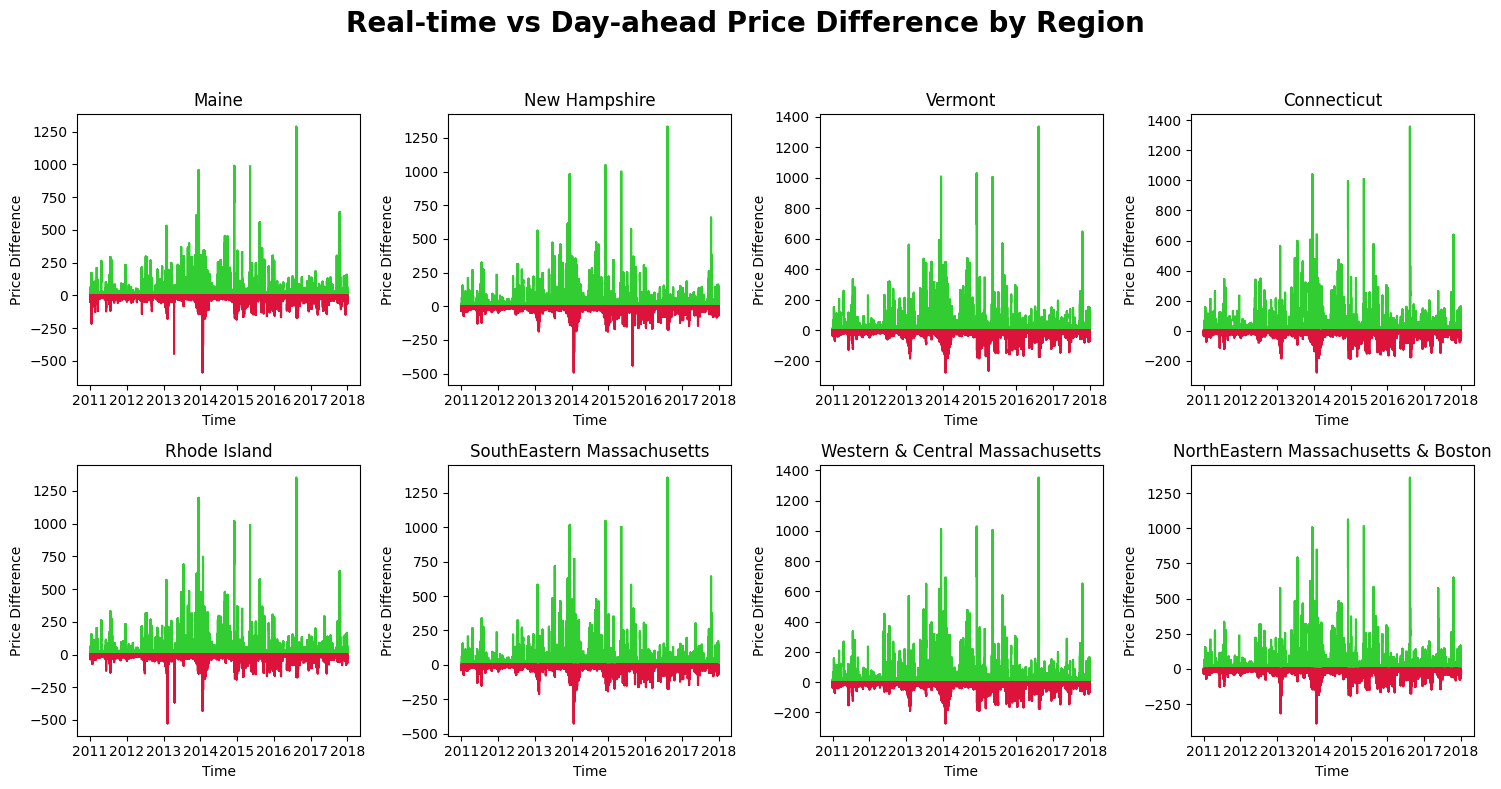

In [18]:
fig, axes = plt.subplots(2, 4, figsize=(15, 8))  # Creates a 2x4 grid of subplots

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through each DataFrame and corresponding title
for i, (df, name) in enumerate(zip(state_dfs[1:], state_names_full[1:])):  # Assuming state_names matches state_dfs
    ax = axes[i]
    
    # Plot positive and negative values separately
    positive = df['Price Diff'].where(df['Price Diff'] >= 0)
    negative = df['Price Diff'].where(df['Price Diff'] < 0)
    
    ax.plot(df.index, positive, color='#32CD32', label='Positive')
    ax.plot(df.index, negative, color='#DC143C', label='Negative')
    
    # Add titles and labels
    ax.set_title(name)
    ax.set_ylabel('Price Difference')
    ax.set_xlabel('Time')

fig.suptitle('Real-time vs Day-ahead Price Difference by Region', fontsize=20, fontweight='bold')

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the rect to leave space for the suptitle

plt.show()

### Generation Mix

In [19]:
final_genmix_df_melted = final_genmix_df.melt(id_vars=['Date'], var_name='Fuel Type', value_name='Demand')
final_genmix_df_melted['Date'] = pd.to_datetime(final_genmix_df_melted['Date'])

final_genmix_df_melted.head()

,Date,Fuel Type,Demand
0,2011-01-01,Coal,20552.396
1,2011-01-02,Coal,20163.527
2,2011-01-03,Coal,27166.663
3,2011-01-04,Coal,38256.357
4,2011-01-05,Coal,39574.746


In [36]:
# List of fuel types you want to filter
fuel_types = ['Coal', 'Gas', 'Nuclear', 'Hydro']

# Filter the DataFrame
filtered_genmix_df = final_genmix_df_melted[final_genmix_df_melted['Fuel Type'].isin(fuel_types)]

print(filtered_genmix_df.head())


        Date Fuel Type     Demand
0 2011-01-01      Coal  20552.396
1 2011-01-02      Coal  20163.527
2 2011-01-03      Coal  27166.663
3 2011-01-04      Coal  38256.357
4 2011-01-05      Coal  39574.746


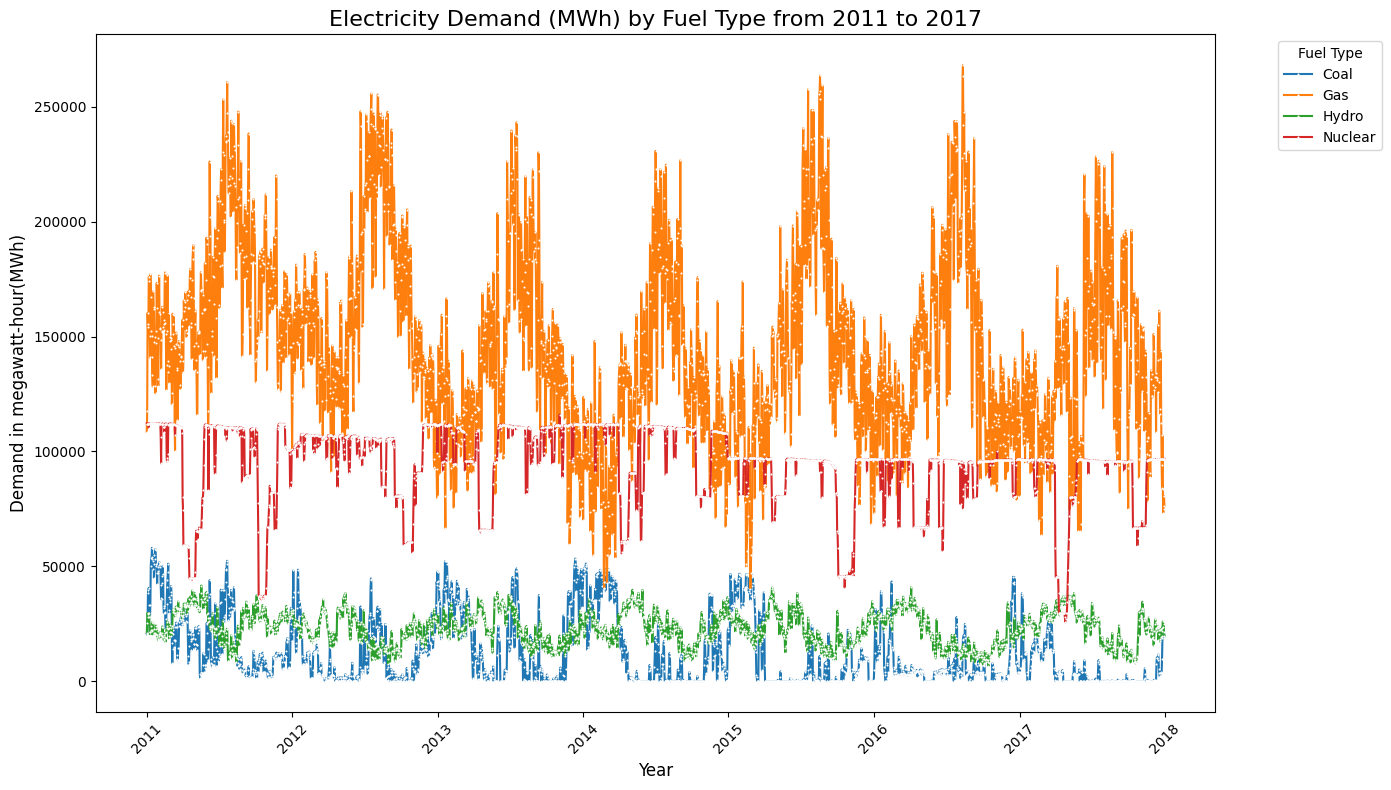

In [41]:
custom_palette = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

plt.figure(figsize=(14, 8))
sns.lineplot(data=filtered_genmix_df, x='Date', y='Demand', hue='Fuel Type', marker='x', markersize=1)
plt.title('Electricity Demand (MWh) by Fuel Type from 2011 to 2017', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Demand in megawatt-hour(MWh)', fontsize=12)
plt.legend(title='Fuel Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

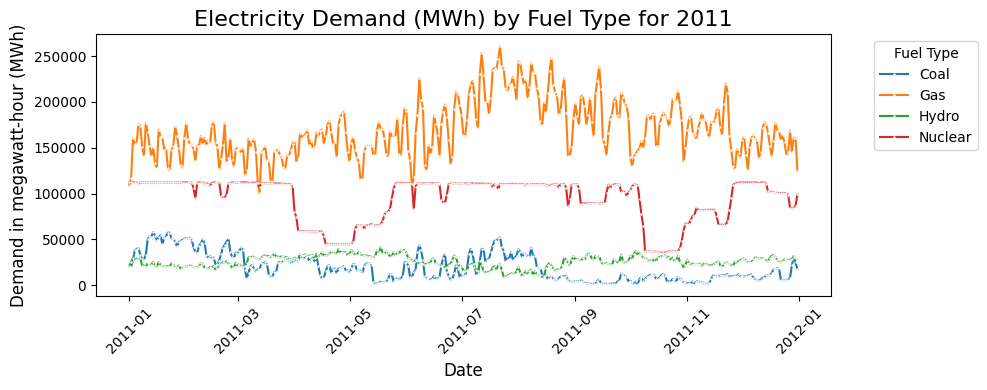

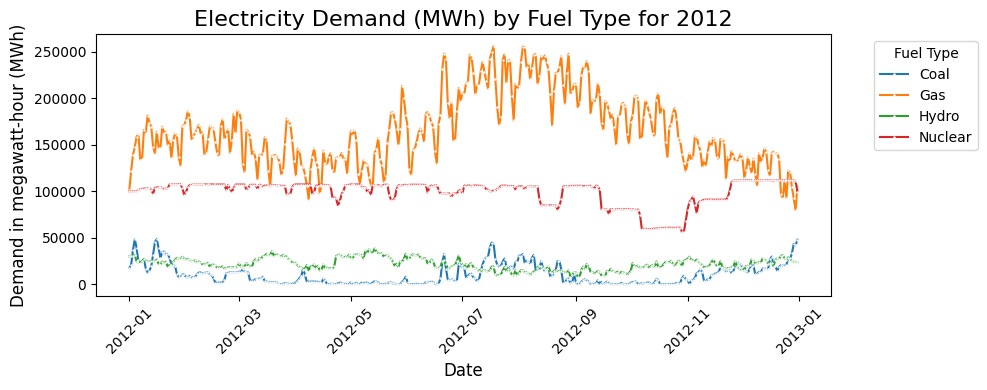

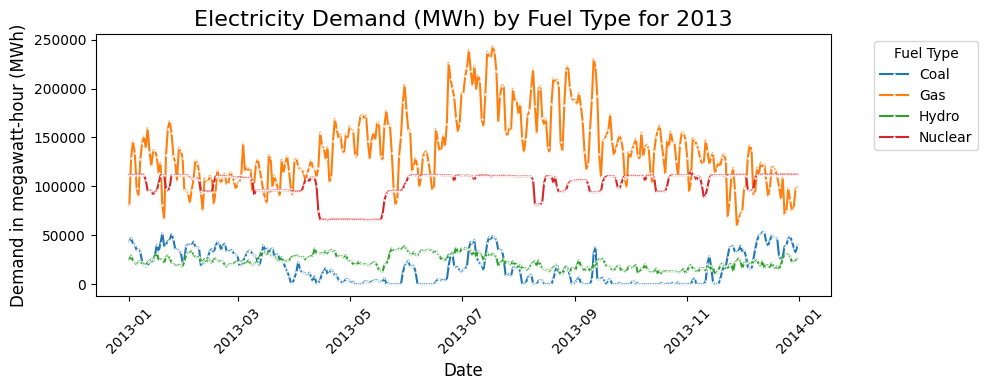

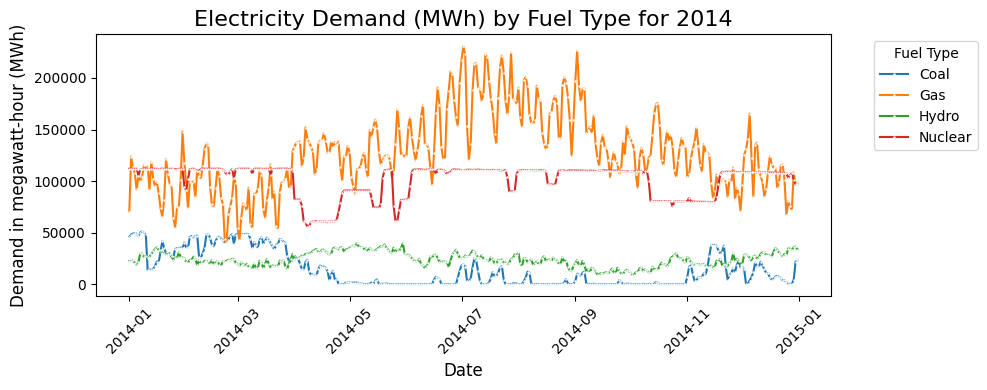

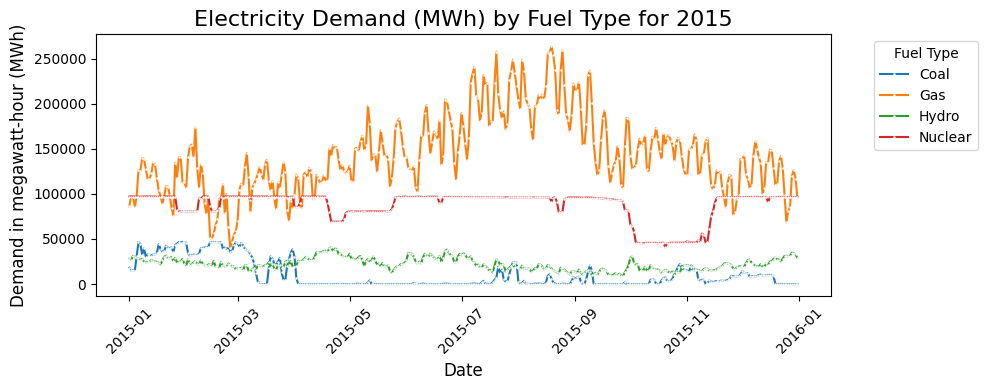

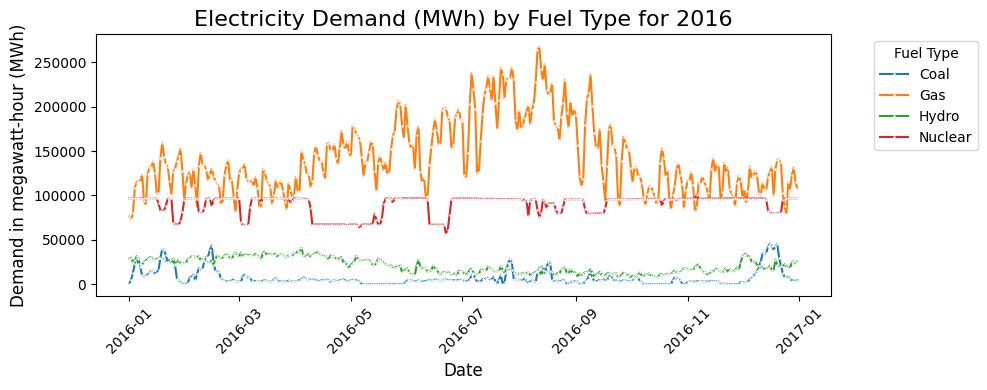

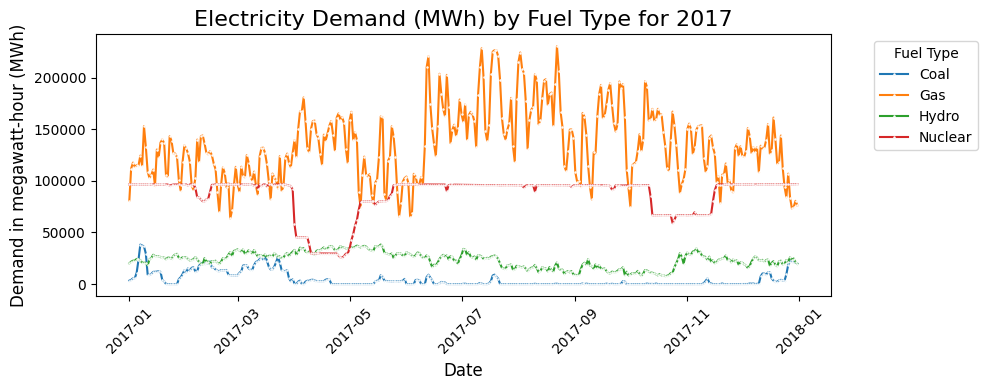

In [42]:
for year in range(2011, 2018):
    plt.figure(figsize=(10, 4))

    year_data_genmix = filtered_genmix_df[filtered_genmix_df["Date"].dt.year == year]

    sns.lineplot(data=year_data_genmix, x='Date', y='Demand', hue='Fuel Type', marker='o', markersize=1)
    
    plt.title(f'Electricity Demand (MWh) by Fuel Type for {year}', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Demand in megawatt-hour (MWh)', fontsize=12)
    plt.legend(title='Fuel Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45)
    

    plt.tight_layout()
    plt.show()

## Running Regression